# Import Libraries

In [56]:
import spacy
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import pandas as pd  # Assuming parsed_data is a pandas DataFrame
import networkx as nx
from fastcoref import spacy_component

In [57]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_lg

# Load Pretrained Models

In [58]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

# Functions

In [59]:
MAX_TOKEN_LENGTH = 1024

In [60]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"] if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [61]:
# Extract relations from model output
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
    return relations

In [62]:
# Function to chunk text if it exceeds the max token length
def chunk_text(text, max_length=MAX_TOKEN_LENGTH):
    inputs = tokenizer(text, return_tensors="pt", truncation=False)
    token_ids = inputs["input_ids"][0]

    # Check if the token length exceeds the model's max token limit
    if len(token_ids) <= max_length:
        return [text]  # No need to chunk if it's within the limit

    # If it exceeds, split the text into smaller chunks
    chunks = []
    chunk_size = max_length - 10  # Reserve some space for any edge cases
    for i in range(0, len(token_ids), chunk_size):
        chunk_ids = token_ids[i:i+chunk_size]
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)
        chunks.append(chunk_text)

    return chunks

In [63]:
nlp_coref = spacy.load("en_core_web_lg", exclude=["parser", "lemmatizer", "ner", "textcat"])
nlp_lemmatizer = spacy.load("en_core_web_lg")  # Include lemmatizer for this pipeline
nlp_coref.add_pipe("fastcoref") # Add FastCoref to the coref pipeline

# Function to extract relations from text using chunking
def from_text_to_kb(text, span_length=128, verbose=False):
    # Chunk the text if necessary
    OG_chunks = chunk_text(text, max_length=MAX_TOKEN_LENGTH)
    # print(f"OG_chunks: {OG_chunks}")

    # First, process the chunk with the coreference resolution pipeline
    doc_coref = nlp_coref(OG_chunks[0], component_cfg={"fastcoref": {'resolve_text': True}})
    resolved_text = doc_coref._.resolved_text
    # print(f"resolved_text: {resolved_text}")

    # Then, pass the resolved text through the lemmatization pipeline
    doc_lemmatized = nlp_lemmatizer(resolved_text)
    lemmatized_text = " ".join([token.lemma_ for token in doc_lemmatized])
    # print(f"lemmatized_text: {lemmatized_text}")

    chunks = [lemmatized_text] # To maintain the integrity of the existing code

    # Initialize the KB object to store all relations
    kb = KB()

    for chunk in chunks:
        inputs = tokenizer([chunk], return_tensors="pt")

        # Compute span boundaries
        num_tokens = len(inputs["input_ids"][0])
        if verbose:
            print(f"Chunk input has {num_tokens} tokens")
        num_spans = math.ceil(num_tokens / span_length)
        if verbose:
            print(f"Chunk has {num_spans} spans")
        overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))

        spans_boundaries = []
        start = 0
        for i in range(num_spans):
            spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
            start -= overlap
        if verbose:
            print(f"Span boundaries are {spans_boundaries}")

        # Transform input with spans
        tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
        inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

        # Generate relations
        num_return_sequences = 3
        gen_kwargs = {"max_length": 256, "length_penalty": 0, "num_beams": 3, "num_return_sequences": num_return_sequences}
        generated_tokens = model.generate(**inputs, **gen_kwargs)

        # Decode relations
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

        # Add relations to KB
        i = 0
        for sentence_pred in decoded_preds:
            current_span_index = i // num_return_sequences
            relations = extract_relations_from_model_output(sentence_pred)
            for relation in relations:
                relation["meta"] = {"spans": [spans_boundaries[current_span_index]]}
                kb.add_relation(relation)
            i += 1

    return kb

10/19/2024 10:35:14 - INFO - 	 missing_keys: []
10/19/2024 10:35:14 - INFO - 	 unexpected_keys: []
10/19/2024 10:35:14 - INFO - 	 mismatched_keys: []
10/19/2024 10:35:14 - INFO - 	 error_msgs: []
10/19/2024 10:35:14 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M


In [64]:
# Build knowledge graph from KB
def build_knowledge_graph_from_kb(kb):
    G = nx.Graph()

    # Add relations to the graph
    for relation in kb.relations:
        head = relation['head']
        tail = relation['tail']
        rel_type = relation['type']
        G.add_edge(head, tail, label=rel_type)

    return G

In [65]:
# Visualize the knowledge graph
def visualize_knowledge_graph(G):
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=15, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
    plt.show()

In [66]:
# Process each passage in the DataFrame and build the overall knowledge graph
def process_dataframe_and_build_kg(df):
    # Initialize an empty KB to store all relations
    combined_kb = KB()

    # Iterate over each passage in the DataFrame
    for ind, row in df.iterrows():
        text = row['passage_text']  # Extract the text of each passage

        # Extract KB for this specific passage
        passage_kb = from_text_to_kb(text)

        # Add all relations from this passage into the combined KB
        for relation in passage_kb.relations:
            combined_kb.add_relation(relation)

    # Build the knowledge graph from the combined KB
    G = build_knowledge_graph_from_kb(combined_kb)

    # Visualize the final knowledge graph
    visualize_knowledge_graph(G)

    return G

# Data Processing

In [67]:
INPUT_DATASET = "../GraphRAG/input/dataset0.txt"

import re
import pandas as pd

# Function to parse the text dataset
def parse_dataset(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    records = content.split("----------")

    dataset = []

    query_pattern = re.compile(r"Query:\s*(.*)")
    query_id_pattern = re.compile(r"Query_id:\s*(\d+)")
    query_type_pattern = re.compile(r"Query_type:\s*(\w+)")
    answers_pattern = re.compile(r"Answers:\s*(.*)")
    passage_text_pattern = re.compile(r"passage_text:\s*(.*?)(?:url:|$)", re.DOTALL)
    url_pattern = re.compile(r"url:\s*(.*)", re.DOTALL)

    for record in records:
        record = record.strip()
        if not record:
            continue

        query_match = query_pattern.search(record)
        query_id_match = query_id_pattern.search(record)
        query_type_match = query_type_pattern.search(record)
        answers_match = answers_pattern.search(record)
        passage_text_match = passage_text_pattern.search(record)
        url_match = url_pattern.search(record)

        entry = {
            "Query": query_match.group(1).strip() if query_match else None,
            "Query_id": query_id_match.group(1).strip() if query_id_match else None,
            "Query_type": query_type_match.group(1).strip() if query_type_match else None,
            "Answers": answers_match.group(1).strip() if answers_match else None,
            "passage_text": passage_text_match.group(1).strip() if passage_text_match else None,
            "url": url_match.group(1).strip() if url_match else None
        }

        dataset.append(entry)

    return dataset

parsed_data = parse_dataset(INPUT_DATASET)
parsed_data = pd.DataFrame(parsed_data)
parsed_data.to_csv("dataset.csv", index=False)

# Construct KG

In [68]:
df = pd.read_csv("dataset.csv")
df.head()

,Query,Query_id,Query_type,Answers,passage_text,url
0,. what is a corporation?,1102432,DESCRIPTION,A corporation is a company or group of people authorized to act as a single entity and recognized as such in law.,"A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or province. The corporation is then governed by the laws of incorporation in that state. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, the corporation will usually be governed by its shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1 He works as a consultant for several large corporations. 2 a substantial corporation that showed that he was a sucker for all-you-can-eat buffets. 1: a government-owned corporation (as a utility or railroad) engaged in a profit-making enterprise that may require the exercise of powers unique to government (as eminent domain) — called also government corporation, publicly held corporation McDonald's Corporation is one of the most recognizable corporations in the world. A corporation is a company or group of people authorized to act as a single entity (legally a person) and recognized as such in law. Early incorporated entities were established by charter (i.e. by an ad hoc act granted by a monarch or passed by a parliament or legislature). Corporations are owned by their stockholders (shareholders) who share in profits and losses generated through the firm's operations, and have three distinct characteristics (1) Legal existence: a firm can (like a person) buy, sell, own, enter into a contract, and sue other persons and firms, and be sued by them. An Association is an organized group of people who share in a common interest, activity, or purpose. 1 Start a business Plan your business. Create your business structure Types of business structures. 2 Change or update your business Add a new location to your existing business. Add an endorsement to your existing business. B Corp certification shines a light on the companies leading the global movement... LLCs offer greater flexibility when it comes to income taxes. 1 The owner or member of an LLC can have their income taxed in three ways: 2 A single owner LLC is treated as a Schedule C (sole proprietor) for tax purposes.","http://www.wisegeek.com/what-is-a-corporation.htm, https://www.bcorporation.net/what-are-b-corps, http://www.dictionary.com/browse/corporation, https://www.merriam-webster.com/dictionary/corporation, https://www.merriam-webster.com/dictionary/corporation, https://en.wikipedia.org/wiki/Corporation, http://www.businessdictionary.com/definition/corporation.html, http://bls.dor.wa.gov/ownershipstructures.aspx, https://www.bcorporation.net/, http://www.investorwords.com/article/s-corporation-vs-llc.html"
1,why did rachel carson write an obligation to endure,1102431,DESCRIPTION,"Rachel Carson writes The Obligation to Endure because believes that as man tries to eliminate unwanted insects and weeds, however he is actually causing more problems by polluting the environment.","Read to write - grow a love of books (even if it's a comic book) Organizing an argument into paragraphs, words [that] worked together for a common purpose Walker: Using models - read other research papers, look at MLA samples Maintain a larger perspective of the world and in your writing - stay objective Write about what fascinates you Carson subtly defers her writing in just the r

10/19/2024 10:35:14 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:35:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:35:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:35:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:35:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:35:37 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:35:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:35:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:35:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:35:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:36:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:36:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:36:10 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:36:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:36:30 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:36:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:36:37 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:36:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:37:33 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:37:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:37:38 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:37:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:37:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:37:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:37:53 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:37:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:38:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:38:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:38:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:38:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:38:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:38:29 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:38:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:38:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:38:52 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:38:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:39:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:39:08 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:39:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:39:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:39:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:39:47 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:40:08 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:40:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:40:14 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:40:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:40:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:40:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:40:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:40:33 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:40:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:40:42 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:40:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:40:56 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:41:03 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:41:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:25 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:41:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:41:37 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:41:48 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:53 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:41:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:41:58 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:08 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:14 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:15 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:30 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:40 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:42 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:48 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:49 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:42:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:42:57 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:43:03 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:43:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:43:10 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:43:11 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:43:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:43:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:43:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:43:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:43:49 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:43:51 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:43:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:43:58 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:44:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:44:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:44:16 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:44:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:44:24 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:44:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:45:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:45:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:45:27 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:45:29 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:45:35 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:45:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:45:58 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:46:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:46:05 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:46:07 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:46:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:46:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:46:33 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:46:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:46:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:46:46 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:47:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:47:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:47:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:47:24 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:47:29 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:47:30 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:47:37 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:47:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:47:49 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:47:50 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:47:55 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:47:57 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:04 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:05 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:12 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:20 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:21 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:24 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:26 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:31 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:45 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:48:51 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:48:53 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:49:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:49:03 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:49:13 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:49:14 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:49:31 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:49:33 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:49:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:49:55 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:50:01 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:50:03 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:52:39 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:52:40 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:53:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:53:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:53:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:53:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:53:31 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:53:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:53:39 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:53:40 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:53:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:53:47 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:53:54 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:53:55 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:03 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:08 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:09 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:17 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:18 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:25 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:27 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:40 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:42 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:48 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:54:56 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:54:58 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:55:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:55:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:55:12 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:55:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:55:19 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:55:20 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:55:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:55:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:56:21 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:56:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:56:30 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:56:31 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:56:37 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:56:39 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:56:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:56:46 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:57:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:57:03 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:57:10 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:57:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 10:57:15 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:57:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

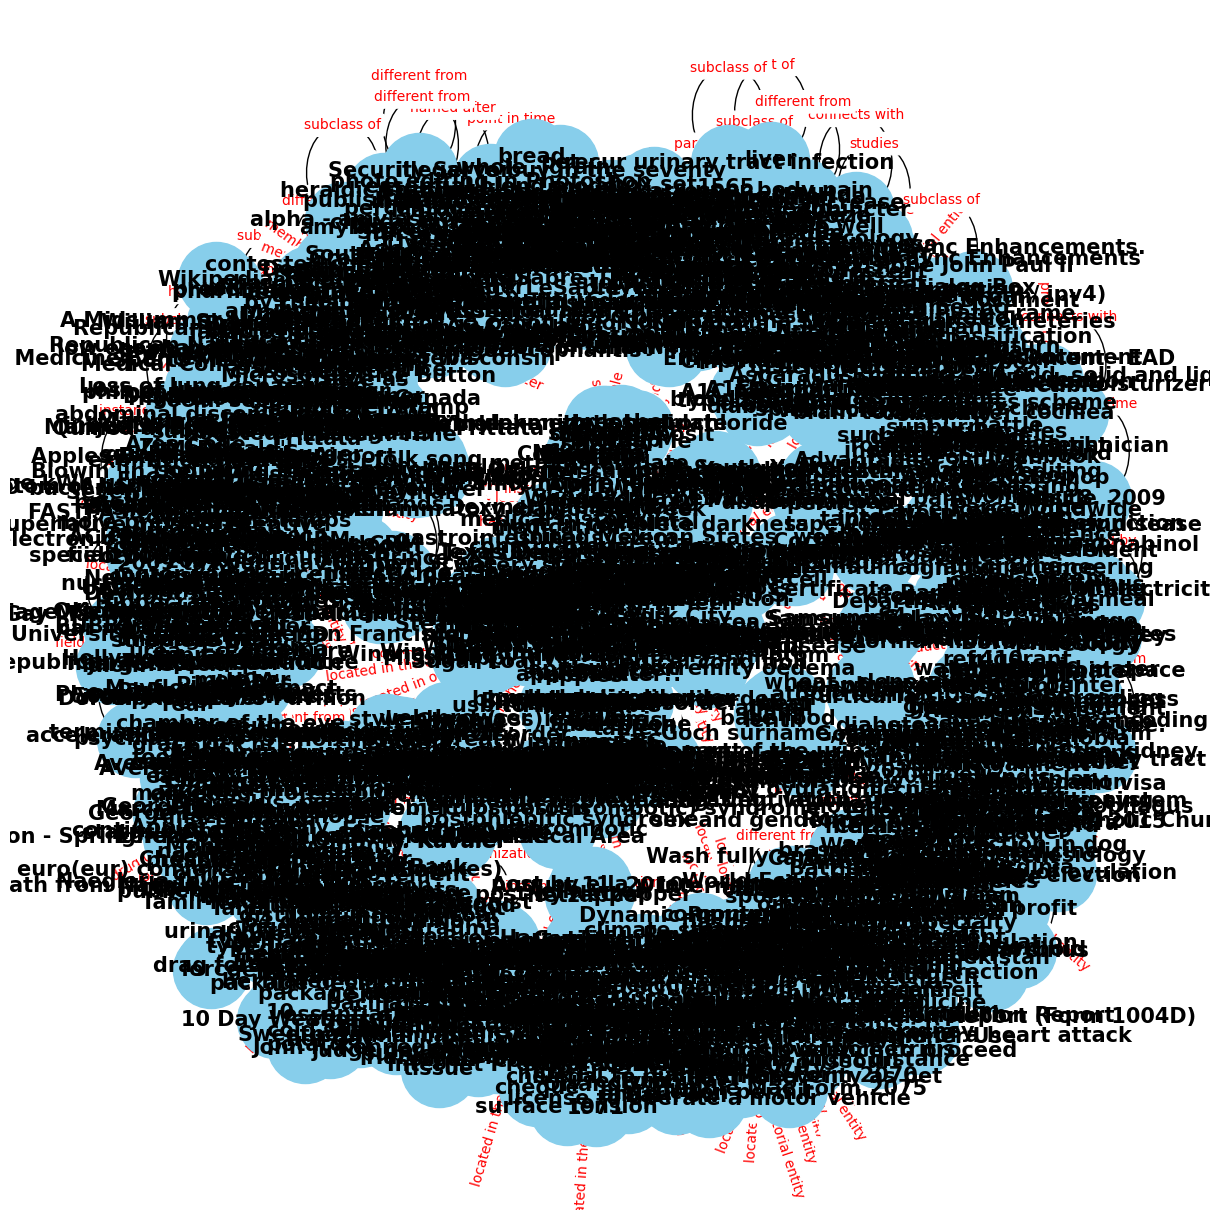

In [69]:
G = process_dataframe_and_build_kg(df)

In [70]:
nx.write_graphml(G, "knowledge_graph.graphml")

# Investigations

In [43]:
phrase = "fallacy"

# Filter rows where any column contains the phrase (case insensitive)
filtered_df = df[df.apply(lambda row: row.astype(str).str.contains(phrase, case=False, na=False).any(), axis=1)]
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to the next line
pd.set_option('display.max_colwidth', None)  # To ensure no truncation of text in cells
# Show the filtered rows fully
print(filtered_df)

                                                 Query  Query_id   Query_type                                                                                                                                                                                               Answers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [49]:
phrase = "publicly"

# Filter rows where any column contains the phrase (case insensitive)
filtered_df = df[df.apply(lambda row: row.astype(str).str.contains(phrase, case=False, na=False).any(), axis=1)]
filtered_df

,Query,Query_id,Query_type,Answers,passage_text,url
0,. what is a corporation?,1102432,DESCRIPTION,A corporation is a company or group of people authorized to act as a single entity and recognized as such in law.,"A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or province. The corporation is then governed by the laws of incorporation in that state. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, the corporation will usually be governed by its shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1 He works as a consultant for several large corporations. 2 a substantial corporation that showed that he was a sucker for all-you-can-eat buffets. 1: a government-owned corporation (as a utility or railroad) engaged in a profit-making enterprise that may require the exercise of powers unique to government (as eminent domain) — called also government corporation, publicly held corporation McDonald's Corporation is one of the most recognizable corporations in the world. A corporation is a company or group of people authorized to act as a single entity (legally a person) and recognized as such in law. Early incorporated entities were established by charter (i.e. by an ad hoc act granted by a monarch or passed by a parliament or legislature). Corporations are owned by their stockholders (shareholders) who share in profits and losses generated through the firm's operations, and have three distinct characteristics (1) Legal existence: a firm can (like a person) buy, sell, own, enter into a contract, and sue other persons and firms, and be sued by them. An Association is an organized group of people who share in a common interest, activity, or purpose. 1 Start a business Plan your business. Create your business structure Types of business structures. 2 Change or update your business Add a new location to your existing business. Add an endorsement to your existing business. B Corp certification shines a light on the companies leading the global movement... LLCs offer greater flexibility when it comes to income taxes. 1 The owner or member of an LLC can have their income taxed in three ways: 2 A single owner LLC is treated as a Schedule C (sole proprietor) for tax purposes.","http://www.wisegeek.com/what-is-a-corporation.htm, https://www.bcorporation.net/what-are-b-corps, http://www.dictionary.com/browse/corporation, https://www.merriam-webster.com/dictionary/corporation, https://www.merriam-webster.com/dictionary/corporation, https://en.wikipedia.org/wiki/Corporation, http://www.businessdictionary.com/definition/corporation.html, http://bls.dor.wa.gov/ownershipstructures.aspx, https://www.bcorporation.net/, http://www.investorwords.com/article/s-corporation-vs-llc.html"
43,how fast does a apple charge your phone,233659,NUMERIC,No Answer Present.,"Here is the name of a USB Hub that has ONE fast charge port they call it that is the same as the iPad Charger: Symba 7 Port USB 3.0/2.0 Hub with One Fast Charging USB 2.0 Port (SD-HUB20102) if you want to charge fast and sync your iPad on your computer. See, the default power adapter that comes with the iPhone 6 and iPhone 6 Plus provides a 1 amp (5 W) power supply. But your phone will charge faster if you connect it to a 2.1 amp (12 W) supply instead, like the type that comes with the new Apple iPad Air. If it takes your iPad charger 5 hours to charge up your iPad with the

In [42]:

# Initialize an empty KB to store all relations
combined_kb = KB()

# Iterate over each passage in the DataFrame
for ind, row in df.iterrows():
    text = row['passage_text']  # Extract the text of each passage

    # Extract KB for this specific passage
    passage_kb = from_text_to_kb(text)

    # Add all relations from this passage into the combined KB
    for relation in passage_kb.relations:
        combined_kb.add_relation(relation)

    if ind > 5:
        break

10/19/2024 09:36:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:36:35 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 09:36:41 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:36:42 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 09:36:51 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:36:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 09:36:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:37:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 09:37:07 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:37:08 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 09:37:16 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:37:17 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

10/19/2024 09:37:24 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 09:37:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
combined_kb.print()

Relations:
  {'head': 'province', 'type': 'subclass of', 'tail': 'state', 'meta': {'spans': [[0, 128]]}}
  {'head': 'non - stock corporation', 'type': 'subclass of', 'tail': 'stock', 'meta': {'spans': [[0, 128]]}}
  {'head': 'non - stock corporation', 'type': 'subclass of', 'tail': 'stock corporation', 'meta': {'spans': [[0, 128]]}}
  {'head': 'utility', 'type': 'subclass of', 'tail': 'own corporation', 'meta': {'spans': [[104, 232]]}}
  {'head': 'railroad', 'type': 'subclass of', 'tail': 'own corporation', 'meta': {'spans': [[104, 232]]}}
  {'head': 'utility', 'type': 'subclass of', 'tail': 'utility', 'meta': {'spans': [[104, 232]]}}
  {'head': "McDonald 's Corporation", 'type': 'instance of', 'tail': 'publicly hold corporation', 'meta': {'spans': [[208, 336]]}}
  {'head': 'public hold corporation', 'type': 'subclass of', 'tail': 'corporation', 'meta': {'spans': [[208, 336]]}}
  {'head': 'parliament', 'type': 'subclass of', 'tail': 'legislature', 'meta': {'spans': [[312, 440]]}}
  {'h

In [50]:
df.passage_text[0]

"A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or province. The corporation is then governed by the laws of incorporation in that state. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, the corporation will usually be governed by its shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1  He works as a consultant for several large corporations. 2  a substanti

In [52]:
OG_chunks = chunk_text(df.passage_text[0], max_length=MAX_TOKEN_LENGTH)
print(f"OG_chunks: {OG_chunks}")

# First, process the chunk with the coreference resolution pipeline
doc_coref = nlp_coref(OG_chunks[0], component_cfg={"fastcoref": {'resolve_text': True}})
resolved_text = doc_coref._.resolved_text
print(f"resolved_text: {resolved_text}")

# Then, pass the resolved text through the lemmatization pipeline
doc_lemmatized = nlp_lemmatizer(resolved_text)
lemmatized_text = " ".join([token.lemma_ for token in doc_lemmatized])
print(f"lemmatized_text: {lemmatized_text}")

10/19/2024 10:10:22 - INFO - 	 Tokenize 1 inputs...


OG_chunks: ["A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or province. The corporation is then governed by the laws of incorporation in that state. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, the corporation will usually be governed by its shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1  He works as a consultant for several large corporations. 2 

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

10/19/2024 10:10:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

resolved_text: A company is incorporated in a specific nation, often within the bounds of a smaller subset of a specific nation, such as a state or province. A company is then governed by the laws of incorporation in a specific nation. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, A corporation will usually be governed by A corporation's shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1  He works as a consultant for several lar

In [ ]:
# Output from cell just above

# OG_chunks: ["A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or province. The corporation is then governed by the laws of incorporation in that state. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, the corporation will usually be governed by its shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1  He works as a consultant for several large corporations. 2  a substantial corporation that showed that he was a sucker for all-you-can-eat buffets. 1: a government-owned corporation (as a utility or railroad) engaged in a profit-making enterprise that may require the exercise of powers unique to government (as eminent domain) — called also government corporation, publicly held corporation McDonald's Corporation is one of the most recognizable corporations in the world. A corporation is a company or group of people authorized to act as a single entity (legally a person) and recognized as such in law. Early incorporated entities were established by charter (i.e. by an ad hoc act granted by a monarch or passed by a parliament or legislature). Corporations are owned by their stockholders (shareholders) who share in profits and losses generated through the firm's operations, and have three distinct characteristics (1) Legal existence: a firm can (like a person) buy, sell, own, enter into a contract, and sue other persons and firms, and be sued by them. An Association is an organized group of people who share in a common interest, activity, or purpose. 1  Start a business Plan your business. Create your business structure Types of business structures. 2  Change or update your business Add a new location to your existing business. Add an endorsement to your existing business. B Corp certification shines a light on the companies leading the global movement... LLCs offer greater flexibility when it comes to income taxes. 1  The owner or member of an LLC can have their income taxed in three ways: 2  A single owner LLC is treated as a Schedule C (sole proprietor) for tax purposes."]
# resolved_text: A company is incorporated in a specific nation, often within the bounds of a smaller subset of a specific nation, such as a state or province. A company is then governed by the laws of incorporation in a specific nation. A corporation may issue stock, either private or public, or may be classified as a non-stock corporation. If stock is issued, A corporation will usually be governed by A corporation's shareholders, either directly or indirectly. Today, there is a growing community of more than 2,100 Certified B Corps from 50 countries and over 130 industries working together toward 1 unifying goal: to redefine success in business. Join the Movement Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more. Examples of corporation in a Sentence. 1  He works as a consultant for several large corporations. 2  a substantial corporation that showed that he was a sucker for all-you-can-eat buffets. 1: a government-owned corporation (as a utility or railroad) engaged in a profit-making enterprise that may require the exercise of powers unique to government (as eminent domain) — called also government corporation, publicly held corporation McDonald's Corporation is one of the most recognizable corporations in the world. A corporation is a company or group of people authorized to act as a single entity (legally a person) and recognized as such in law. Early incorporated entities were established by charter (i.e. by an ad hoc act granted by a monarch or passed by a parliament or legislature). Corporations are owned by Corporations's stockholders (shareholders) who share in profits and losses generated through the firm's operations, and have three distinct characteristics (1) Legal existence: a firm can (like a person) buy, sell, own, enter into a contract, and sue other persons and firms, and be sued by other persons and firms. An Association is an organized group of people who share in a common interest, activity, or purpose. 1  Start a business Plan your business. Create your business structure Types of business structures. 2  Change or update your business Add a new location to your existing business. Add an endorsement to your existing business. B Corp certification shines a light on the companies leading the global movement... LLCs offer greater flexibility when it comes to income taxes. 1  The owner or member of an LLC can have The owner or member of an LLC's income taxed in three ways: 2  A single owner LLC is treated as a Schedule C (sole proprietor) for tax purposes.
# lemmatized_text: a company be incorporate in a specific nation , often within the bound of a small subset of a specific nation , such as a state or province . a company be then govern by the law of incorporation in a specific nation . a corporation may issue stock , either private or public , or may be classify as a non - stock corporation . if stock be issue , a corporation will usually be govern by a corporation 's shareholder , either directly or indirectly . today , there be a grow community of more than 2,100 Certified B Corps from 50 country and over 130 industry work together toward 1 unifying goal : to redefine success in business . join the Movement Corporation definition , an association of individual , create by law or under authority of law , have a continuous existence independent of the existence of its member , and power and liability distinct from those of its member . see more . example of corporation in a sentence . 1   he work as a consultant for several large corporation . 2   a substantial corporation that show that he be a sucker for all - you - can - eat buffet . 1 : a government - own corporation ( as a utility or railroad ) engage in a profit - make enterprise that may require the exercise of power unique to government ( as eminent domain ) — call also government corporation , publicly hold corporation McDonald 's Corporation be one of the most recognizable corporation in the world . a corporation be a company or group of people authorize to act as a single entity ( legally a person ) and recognize as such in law . early incorporate entity be establish by charter ( i.e. by an ad hoc act grant by a monarch or pass by a parliament or legislature ) . corporation be own by corporation 's stockholder ( shareholder ) who share in profit and loss generate through the firm 's operation , and have three distinct characteristic ( 1 ) legal existence : a firm can ( like a person ) buy , sell , own , enter into a contract , and sue other person and firm , and be sue by other person and firm . an Association be an organized group of people who share in a common interest , activity , or purpose . 1   start a business plan your business . create your business structure Types of business structure . 2   change or update your business add a new location to your exist business . add an endorsement to your exist business . B Corp certification shine a light on the company lead the global movement ... llc offer great flexibility when it come to income taxis . 1   the owner or member of an LLC can have the owner or member of an LLC 's income tax in three way : 2   a single owner LLC be treat as a Schedule c ( sole proprietor ) for tax purpose .

In [54]:
span_length=128
verbose=False

chunks = [lemmatized_text] # To maintain the integrity of the existing code

# Initialize the KB object to store all relations
kb = KB()

for chunk in chunks:
    inputs = tokenizer([chunk], return_tensors="pt")

    # Compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Chunk input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Chunk has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / max(num_spans - 1, 1))

    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i, start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # Transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]] for boundary in spans_boundaries]
    inputs = {"input_ids": torch.stack(tensor_ids), "attention_mask": torch.stack(tensor_masks)}

    # Generate relations
    num_return_sequences = 3
    gen_kwargs = {"max_length": 256, "length_penalty": 0, "num_beams": 3, "num_return_sequences": num_return_sequences}
    generated_tokens = model.generate(**inputs, **gen_kwargs)

    # Decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)


In [55]:
decoded_preds

['<s><triplet> province <subj> state <obj> subclass of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> non - stock corporation <subj> stock <obj> subclass of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> non - stock corporation <subj> stock corporation <obj> subclass of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> utility <subj> own corporation <obj> subclass of <triplet> railroad <subj> own corporation <obj> subclass of</s><pad><pad><pad><pad><pad>',
 '<s><triplet> utility <subj> utility <obj> subclass of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> utility <subj> own corporation <obj> subclass of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 "<s><triplet> McDonald 's Corporation <subj> publicly hold corporation <obj> instance of</s><pad><pad>